In [4]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("output/variant_hierarchy_details.csv")

# Display column names
print("📄 Column names:")
print(df.columns.tolist())

# Sort the DataFrame by the 'Frequency' column in descending order
df_sorted = df.sort_values(by='Frequency', ascending=False)

# Display the top rows
df_sorted.head()

📄 Column names:
['Variant ID', 'Level', 'Frequency', 'Parent ID', 'Event Path']


,Variant ID,Level,Frequency,Parent ID,Event Path
0,0,0,1056,ROOT,A_Create Application → A_Submitted → W_Handle ...
7769,7769,1,1021,0,A_Create Application → W_Complete application ...
7183,7183,1,734,0,A_Create Application → A_Submitted → W_Handle ...
7184,7184,2,451,7183,A_Create Application → A_Submitted → W_Handle ...
7466,7466,2,332,7183,A_Create Application → A_Submitted → W_Handle ...


In [2]:
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"


In [3]:
from collections import defaultdict

# Dictionary to count event weights (weighted by frequency)
event_weights = defaultdict(int)

# Loop through each variant's event path and frequency
for path, freq in zip(df['Event Path'], df['Frequency']):
    events = [event.strip() for event in path.split("→")]
    for event in events:
        event_weights[event] += freq  # Accumulate weight by frequency

# Normalize the weights
max_weight = max(event_weights.values())
normalized_event_weights = {event: weight / max_weight for event, weight in event_weights.items()}

# Display top 10 events by normalized weight
top_events = sorted(normalized_event_weights.items(), key=lambda x: x[1], reverse=True)[:10]

print("🔥 Top 10 most common events (normalized weights):")
for event, weight in top_events:
    print(f"{event}: {weight:.3f}")

🔥 Top 10 most common events (normalized weights):
W_Call after offers: 1.000
W_Validate application: 0.920
W_Complete application: 0.760
W_Call incomplete files: 0.695
W_Handle leads: 0.245
O_Create Offer: 0.213
O_Created: 0.213
O_Sent (mail and online): 0.201
A_Validating: 0.174
A_Create Application: 0.165


,Parent,Child,Added Events,Removed Events,Add Weight,Remove Weight,Edge Weight
0,0,405,"[W_Validate application, A_Validating, O_Returned, O_Accepted, A_Pending]","[A_Cancelled, O_Cancelled]",0.91547,0.01806,0.89741
1,0,1062,"[W_Validate application, A_Validating, O_Returned, O_Accepted, A_Pending]","[A_Submitted, W_Handle leads, A_Cancelled, O_Cancelled]",0.91547,0.09821,0.81726
2,7184,7233,[W_Complete application],[],0.21986,0.00000,0.21986
3,0,7183,[W_Complete application],[],0.10993,0.00000,0.10993
4,7183,7184,[W_Complete application],[],0.10993,0.00000,0.10993
5,7184,7236,[W_Complete application],[],0.10993,0.00000,0.10993
6,405,712,[W_Complete application],[],0.10993,0.00000,0.10993
7,0,7769,[],"[A_Submitted, W_Handle leads]",0.00000,0.08015,-0.08015
8,7183,7466,[],[W_Complete application],0.00000,0.21986,-0.21986


/var/folders/pd/yy3pmyf5463d74mfp0yr9gsh0000gp/T/ipykernel_94342/2362577617.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


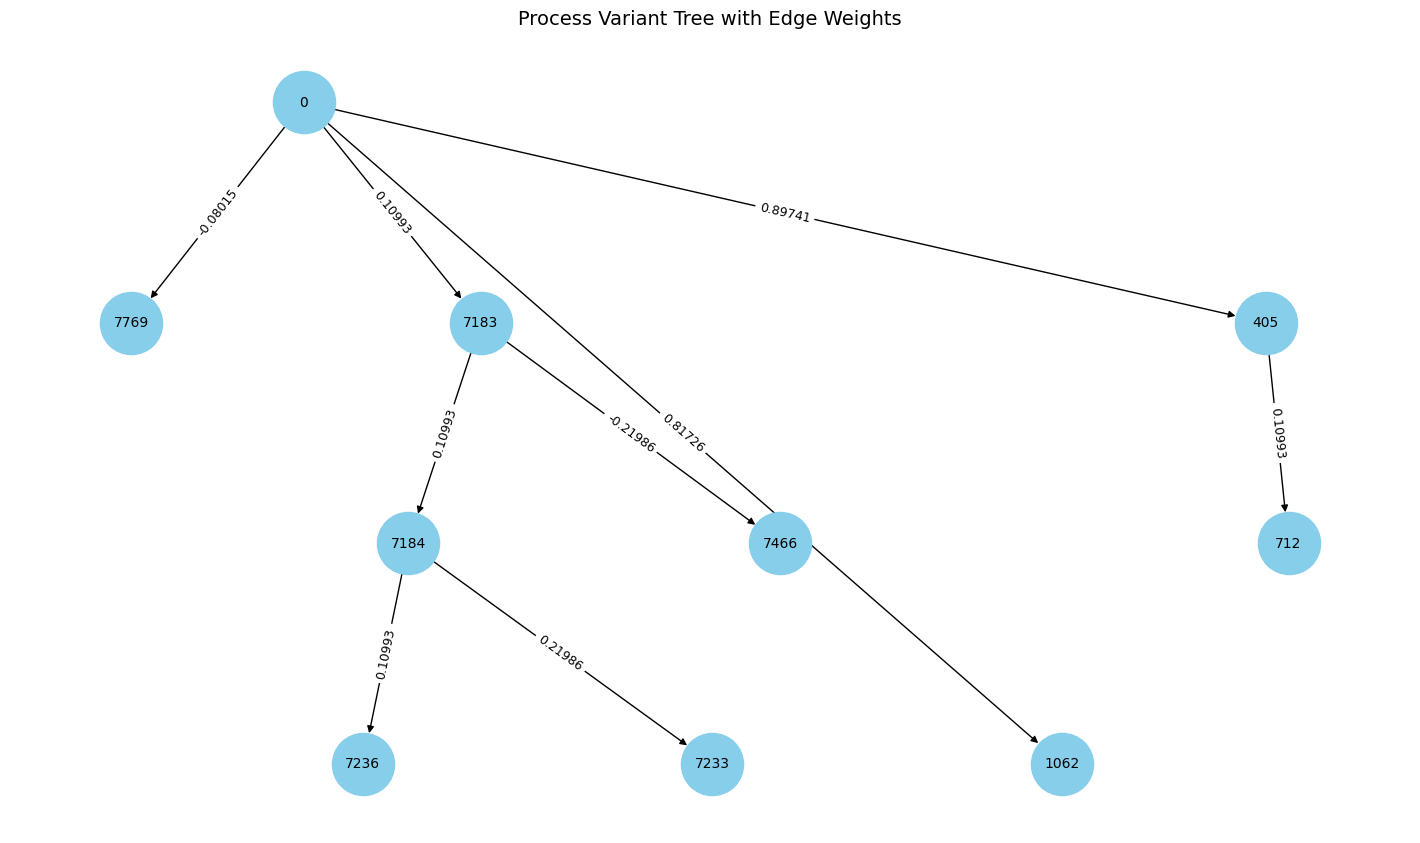

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout

# Ensure correct types
df["Parent ID"] = df["Parent ID"].replace("ROOT", -1)
df["Parent ID"] = pd.to_numeric(df["Parent ID"], errors='coerce')
df["Variant ID"] = pd.to_numeric(df["Variant ID"], errors='coerce')

# Get top 10 variants by frequency
top_variants_df = df.sort_values(by="Frequency", ascending=False).head(10)

# Compute global event weights (normalized)
all_events = []
for path in df["Event Path"]:
    all_events.extend(path.split(" → "))

event_freq = Counter(all_events)
total_events = sum(event_freq.values())
event_weights = {e: f / total_events for e, f in event_freq.items()}

# Build variant ID to event path mapping
variant_map = {
    int(row["Variant ID"]): row["Event Path"].split(" → ")
    for _, row in df.iterrows()
}

# Compute edge weights
edge_weights = []
for _, row in top_variants_df.iterrows():
    child_id = int(row["Variant ID"])
    parent_id = int(row["Parent ID"])

    if parent_id == -1 or parent_id not in variant_map:
        continue  # skip if parent doesn't exist

    child_events = Counter(variant_map[child_id])
    parent_events = Counter(variant_map[parent_id])

    added = child_events - parent_events
    removed = parent_events - child_events

    add_weight = sum(event_weights.get(e, 0) * c for e, c in added.items())
    remove_weight = sum(event_weights.get(e, 0) * c for e, c in removed.items())
    total_weight = round(add_weight - remove_weight, 5)

    edge_weights.append({
        "Parent": parent_id,
        "Child": child_id,
        "Added Events": list(added),
        "Removed Events": list(removed),
        "Add Weight": round(add_weight, 5),
        "Remove Weight": round(remove_weight, 5),
        "Edge Weight": total_weight
    })

# ✅ Display Table
if edge_weights:
    edge_weights_df = pd.DataFrame(edge_weights)
    edge_weights_df = edge_weights_df.sort_values(by="Edge Weight", ascending=False).reset_index(drop=True)
    pd.set_option('display.max_colwidth', None)
    display(edge_weights_df)
else:
    print("⚠️ No valid parent-child relationships found among top 10 variants.")

# ✅ Visualize Tree if possible
if edge_weights:
    G = nx.DiGraph()

    # Add nodes and weighted edges
    for edge in edge_weights:
        G.add_edge(edge["Parent"], edge["Child"], weight=edge["Edge Weight"])

    pos = graphviz_layout(G, prog="dot")  # Requires pygraphviz
    edge_labels = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, with_labels=True, arrows=True,
            node_size=2000, node_color="skyblue", font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    plt.title("Process Variant Tree with Edge Weights", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
